In [1]:
import pandas as pd
import numpy as np
import jieba
import warnings
warnings.filterwarnings("ignore")

## 读取好评差评文本，文本处理

In [2]:
pos = pd.read_csv('comment_con 好评.csv').values.tolist()
neg = pd.read_csv('comment_con 差评.csv').values.tolist()

def context_cut(sentence):
    words_list=[]
    #获取停用词
    stop=open('stopwords/cn_stopwords.txt', 'r', encoding='utf-8')
    stopwords=stop.read().split('\n') + [' ','*','\n','hellip']
    cut_words=list(jieba.cut(sentence))
    for word in cut_words:
        if not(word in stopwords):
            words_list.append(word)
        words_str=','.join(words_list)
    return words_str,words_list

words=[]
word_list=[]
for i in neg:
    cut_words_str,cut_words_list=context_cut(i[0])
    word_list.append((cut_words_str,-1))
    words.append(cut_words_list)
for j in pos:
    cut_words_str2,cut_words_list2=context_cut(j[0])
    word_list.append((cut_words_str2,1))
    words.append(cut_words_list2)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\hejin\AppData\Local\Temp\jieba.cache
Loading model cost 0.512 seconds.
Prefix dict has been built successfully.


## 划分训练集和测试集

In [3]:
from sklearn.model_selection import train_test_split

x,y=zip(*word_list)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

## 使用Tfidf提取特征

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(analyzer='word', ngram_range=(1,4), max_features=500)
tfidf_x_train = vec.fit_transform(x_train)
tfidf_x_test = vec.fit_transform(x_test)

## LinearSVC模型

In [5]:
from sklearn import svm

classfier = svm.SVC(kernel='linear')
classfier.fit(vec.transform(x_train),y_train)

SVC(kernel='linear')

## 评估

In [6]:
score_train = classfier.score(vec.transform(x_train), y_train) # 训练集score
score_test = classfier.score(vec.transform(x_test), y_test) # 测试集score

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

y_train_hat=classfier.predict(vec.transform(x_train))
precision = accuracy_score(y_train_hat,y_train) # 准确率
recall = recall_score(y_train_hat,y_train) # 召回率
F1 = f1_score(y_train_hat,y_train) # F1值
ROC = roc_auc_score(y_train_hat,y_train) # ROC值

print(f'训练集score: {score_train}\n测试集score: {score_test}\n准确率: {precision}\n召回率: {recall}\nF1值: {F1}\nROC值: {ROC}')

训练集score: 0.9770594369134515
测试集score: 0.9791666666666666
准确率: 0.9770594369134515
召回率: 0.9754901960784313
F1值: 0.9863692688971499
ROC值: 0.9807520910462088


In [7]:
from sklearn.metrics import classification_report
print(classification_report(y_train_hat,y_train, target_names=['负情感','正情感']))

              precision    recall  f1-score   support

         负情感       0.88      0.99      0.93       143
         正情感       1.00      0.98      0.99       816

    accuracy                           0.98       959
   macro avg       0.94      0.98      0.96       959
weighted avg       0.98      0.98      0.98       959



## LDA主题模型

In [9]:
from gensim.models.ldamodel import LdaModel
from gensim import corpora

dictionary = corpora.Dictionary(words)  # 构建词典
corpus = [dictionary.doc2bow(text) for text in words]
ldamodel = LdaModel(corpus, num_topics=10, id2word=dictionary, random_state = 42)
ldamodel.print_topics(num_topics=10)

[(0,
  '0.032*"安装" + 0.017*"非常" + 0.016*"快" + 0.012*"师傅" + 0.011*"不错" + 0.009*"外观" + 0.009*"美的" + 0.008*"服务" + 0.008*"满意" + 0.007*"质量"'),
 (1,
  '0.042*"非常" + 0.029*"安装" + 0.020*"不错" + 0.018*"满意" + 0.017*"师傅" + 0.013*"空调" + 0.012*"快" + 0.011*"服务" + 0.011*"质量" + 0.010*"外观"'),
 (2,
  '0.046*"安装" + 0.044*"效果" + 0.023*"静音" + 0.018*"很快" + 0.016*"外观" + 0.015*"师傅" + 0.015*"空调" + 0.014*"制冷" + 0.013*"送货" + 0.013*"冷暖"'),
 (3,
  '0.042*"安装" + 0.039*"非常" + 0.016*"师傅" + 0.015*"效果" + 0.013*"空调" + 0.012*"服务" + 0.012*"值得" + 0.011*"质量" + 0.011*"不错" + 0.010*"买"'),
 (4,
  '0.035*"安装" + 0.021*"很快" + 0.017*"空调" + 0.016*"师傅" + 0.015*"不错" + 0.014*"非常" + 0.014*"制冷" + 0.012*"物流" + 0.010*"效果" + 0.009*"没有"'),
 (5,
  '0.060*"安装" + 0.031*"师傅" + 0.029*"空调" + 0.015*"非常" + 0.014*"送货" + 0.012*"效果" + 0.012*"外观" + 0.011*"快" + 0.011*"买" + 0.011*"服务"'),
 (6,
  '0.033*"安装" + 0.027*"师傅" + 0.019*"不错" + 0.018*"满意" + 0.014*"空调" + 0.013*"买" + 0.012*"质量" + 0.012*"非常" + 0.010*"物流" + 0.010*"服务"'),
 (7,
  '0.034*"安装" + 0.031*"非常" +

## 根据主题一致性，优化主题数

0.45334817022361873
0.4203210619108001
0.4295283371358387
0.4384712435254164
0.4400100429376198
0.454568140951336
0.45122661525483815
0.46856692982721926
0.47102616176727197
0.4690255864426546
0.47692940344475976
0.4757666270907423
0.4718666559468612
0.46523252269193954


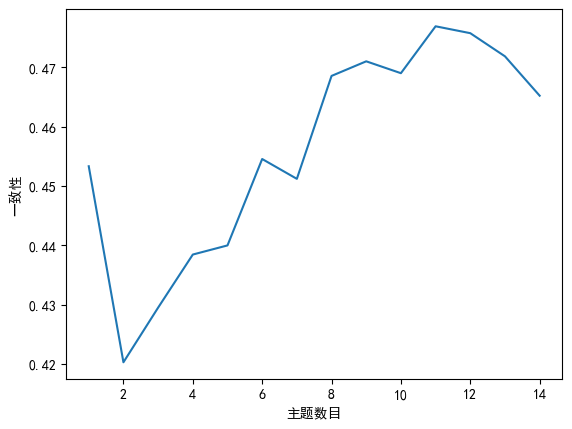

In [13]:
from gensim.models.coherencemodel import CoherenceModel
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.family'] = 'SimHei'
mpl.rcParams['axes.unicode_minus'] = False

def coherence(num_topics):
    ldamodel = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, random_state = 42)
#     print(ldamodel.print_topics(num_topics=num_topics, num_words=10))
    ldacm = CoherenceModel(model=ldamodel, texts=words, dictionary=dictionary, coherence='c_v')
    print(ldacm.get_coherence())
    return ldacm.get_coherence()


x = range(1,15)
y = [coherence(i) for i in x]
plt.plot(x, y)
plt.xlabel('主题数目')
plt.ylabel('一致性')
plt.show()

## 主题数最优为11，建立模型

In [14]:
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=11, random_state=42)
topic_list = lda.print_topics()

print(topic_list)

[(0, '0.035*"安装" + 0.017*"非常" + 0.016*"快" + 0.013*"师傅" + 0.010*"不错" + 0.010*"到货" + 0.009*"美的" + 0.009*"服务" + 0.009*"空调" + 0.009*"外观"'), (1, '0.043*"非常" + 0.033*"安装" + 0.019*"满意" + 0.017*"不错" + 0.017*"师傅" + 0.016*"空调" + 0.012*"快" + 0.011*"买" + 0.011*"服务" + 0.011*"质量"'), (2, '0.048*"安装" + 0.034*"效果" + 0.020*"空调" + 0.020*"很快" + 0.018*"师傅" + 0.016*"静音" + 0.015*"制冷" + 0.013*"外观" + 0.012*"送货" + 0.011*"买"'), (3, '0.045*"安装" + 0.037*"非常" + 0.017*"师傅" + 0.015*"效果" + 0.013*"值得" + 0.012*"服务" + 0.012*"空调" + 0.012*"不错" + 0.011*"买" + 0.010*"质量"'), (4, '0.028*"安装" + 0.020*"空调" + 0.019*"很快" + 0.018*"不错" + 0.013*"师傅" + 0.013*"非常" + 0.012*"制冷" + 0.011*"没有" + 0.010*"物流" + 0.010*"外观"'), (5, '0.056*"安装" + 0.029*"师傅" + 0.027*"空调" + 0.013*"非常" + 0.012*"送货" + 0.012*"外观" + 0.011*"服务" + 0.011*"效果" + 0.011*"特别" + 0.011*"美的"'), (6, '0.034*"安装" + 0.029*"师傅" + 0.019*"不错" + 0.017*"满意" + 0.015*"空调" + 0.014*"买" + 0.014*"质量" + 0.012*"非常" + 0.011*"物流" + 0.010*"美的"'), (7, '0.035*"非常" + 0.034*"安装" + 0.020*"空调" + 0.015*"师傅

In [26]:
topics = []
for i in lda.get_document_topics(corpus)[:]:
    listj=[]
    for j in i:
        listj.append(j[1])
    topics.append(i[listj.index(max(listj))][0])
pd.DataFrame(topics).value_counts() # 所有评论中，主题1最多

1     182
5     157
8     153
6     107
10    107
2     106
3     102
7      95
9      75
4      69
0      46
dtype: int64

## 输出可视化

In [32]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.save_html(data, '主题.html')